# Librairies import

In [4]:
import torch
import gpytorch
from botorch.models import SingleTaskGP
from botorch.acquisition.analytic import LogExpectedImprovement, UpperConfidenceBound
from botorch.optim.optimize import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from matplotlib import pyplot as plt
from torch.optim import Adam
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from datetime import date
import random
import scipy.stats as stats
import scipy.io
import numpy as np
from sklearn.utils import check_random_state
from scipy.stats import ortho_group, norm
from torch.autograd import Variable
from scipy.optimize import minimize
import copy
import pickle
from scipy.stats.qmc import Halton
import torch
from botorch.models import SingleTaskGP
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils import standardize
from gpytorch.kernels import ScaleKernel, RBFKernel
import src.utils.synthetic_datasets
#from ../utils/synthetic_datasets import SyntheticTestFun
from gpytorch.constraints import GreaterThan
import warnings
from botorch.exceptions import OptimizationWarning, InputDataWarning, BadInitialCandidatesWarning
from botorch.utils.transforms import normalize, unnormalize
from botorch.models.utils import gpt_posterior_settings
from botorch.posteriors.torch import TorchPosterior




ModuleNotFoundError: No module named 'src.utils'

# Visualization

In [2]:
def plot_loss(losses, T):
    
    for model_index in range(losses.shape[1]):
        plt.plot(
            range(T),  # Iterations on the x-axis
            losses[:, model_index],  # Performance on the y-axis
            label=f'Model {model_index + 1}'  # Label for the model
        )
    plt.ylim(0.0,2.0) 
    # Add labels, title, and legend
    plt.xlabel("Iteration")
    plt.ylabel("Average Loss")
    plt.title("Loss Over Iterations")
    plt.legend()
    plt.show()

def plot_values(predictions, T):
    plt.figure(figsize=(12, 5))
    plt.plot(range(T), predictions, label="Best candidate solution")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.title("Value Over Iterations")
    plt.legend()
    plt.show()

def plot_partition_updates(model_updates, n_models, T):
    # Prepare the data for eventplot
    events = [[] for _ in range(n_models)]  # One list per model
    for t, updates in enumerate(model_updates):
        for model in updates:
            events[model].append(t)

    # Plot the eventplot
    plt.eventplot(events, orientation='horizontal', lineoffsets=range(n_models), linelengths=0.8)

    # Add labels and title
    plt.xlabel("Iteration (t)")
    plt.ylabel("Model Index (k)")
    plt.title("Eventplot of Model Updates")
    plt.yticks(range(n_models), labels=[f"Model {k+1}" for k in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()

def plot_exploration_exploitation(exploration_performance, exploitation_performance, T):
    
    # Plot exploration performance over iterations
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(
        range(T),  # Iterations on the x-axis
        exploration_performance) # Performance on the y-axis)
    # Add labels, title, and legend
    plt.xlabel('Iteration')
    plt.ylabel('Exploration Performance')
    plt.title('Exploration Score for each Model')
    plt.legend()

    # Plot exploitation performance over iterations
    plt.subplot(1, 2, 2)
    plt.plot(
        range(T),  # Iterations on the x-axis
        exploitation_performance,  # Performance on the y-axis
    )
    plt.xlabel("Iteration")
    plt.ylabel('Exploitation Performance')
    plt.title('Exploitation Score for each Model')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_mae(maes, T):
    for model_index in range(maes.shape[1]):
        plt.plot(
            range(T),  # Iterations on the x-axis
            maes[:, model_index],  # Performance on the y-axis
            label=f'Model {model_index + 1}'  # Label for the model
        )
    plt.xlabel("Iteration")
    plt.ylabel("Mean Abs Error")
    plt.title("MAE Over Iterations")
    plt.legend()
    plt.show()

    

# Additive Structure

In [75]:
class AdditiveStructGP:
    def __init__(self, x_train, y_train, bounds, num_models, n_dims, partition_ratio=0.3, T = 50):
        self.train_x = x_train
        self.train_y = y_train
        self.bounds = bounds
        self.num_models = num_models
        self.acceptance_prob = lambda x: (0.6 + 0.4 * (x / T))
        self.n_dims = n_dims
        self.partition_ratio = partition_ratio
        self.partitions = self.create_partitions()
        self.models = self.initialize_models()
        

    def create_partitions(self):
        """Generate random partitions for the additive structure."""
        partitions = [[random.sample(range(0, self.n_dims), int(self.n_dims/3))] for i in range (self.num_models)] 
        for p in partitions:
            p.append([i for i in range(self.n_dims) if i not in p[0]])
        
        return partitions

    def initialize_models(self):
        """Initialize models for each partition."""
        models = []
        for partition in self.partitions:
            kernel = self.create_kernel_for_partition(partition)
            model = SingleTaskGP(self.train_x, self.train_y)
            model.covar_module = kernel
            #mll = ExactMarginalLogLikelihood(model.likelihood, model)
            #fit_gpytorch_model(mll)
            models.append(model)
        return models
    
    def update_models(self, partitions):
        """Initialize models for each partition."""
        models = []
        for partition in partitions:
            kernel = self.create_kernel_for_partition(partition)
            model = SingleTaskGP(self.train_x, self.train_y)
            model.covar_module = kernel
            #mll = ExactMarginalLogLikelihood(model.likelihood, model)
            #fit_gpytorch_model(mll)
            models.append(model)
        return models

    def create_kernel_for_partition(self, partition):
        """Create a kernel for a given partition."""
        kernels = []
        for subset in partition:
            kernel = ScaleKernel(RBFKernel(active_dims=torch.tensor(subset)))
            kernels.append(kernel)
        combined_kernel = sum(kernels[1:], start=kernels[0])
        return combined_kernel
    
    def forward(self, x):
        """
        As we are considering multiple models (each with a different posterior over f),
        we approximately marginalize out the model by the means of the forward method
        for each k-model.
        """

        means = 0.0
        covars = 0.0
        for model in self.models:

            n = model.posterior(x.unsqueeze(0))
            means += n.mean
            covars += n.variance

        means /= len(self.models)
        covars /= len(self.models)
        covars += torch.eye(covars.size(0)) * 1e-6  

        covar_matrix = torch.diag_embed(covars)

        distr = gpytorch.distributions.MultivariateNormal(means, covar_matrix)

        posterior = TorchPosterior(distribution=distr) ##TODO: Verify if this is acceptable

        return posterior
    
    def forward_weighted(self, x):
        """
        Approximate marginalization over multiple models using weighted evaluation.
        The weights are based on normalized mean absolute errors (MAE).
        """

        mae_list = []

        # Compute MAE for each model
        for model in self.models:
            predictions = model.posterior(self.train_x).mean
            mae = torch.mean(torch.abs(predictions - self.train_y))
            mae_list.append(mae.item())

        # Normalize MAE to compute weights (inverse weighting)
        total_mae = sum(mae_list)
        mae_weights = [1 - (mae / total_mae) for mae in mae_list]

        # Normalize weights to sum to 1
        normalized_weights = [weight / sum(mae_weights) for weight in mae_weights]

        # Initialize weighted means and covariances
        weighted_means = 0.0
        weighted_covars = 0.0

        for model, weight in zip(self.models, normalized_weights):
            posterior = model.posterior(x.unsqueeze(0))
            weighted_means += weight * posterior.mean
            weighted_covars += weight * posterior.variance

        # Add a small jitter for numerical stability
        weighted_covars += torch.eye(weighted_covars.size(0), device) * 1e-6

        # Create covariance matrix
        covar_matrix = torch.diag_embed(weighted_covars)

        # Construct MultivariateNormal distribution
        distr = gpytorch.distributions.MultivariateNormal(weighted_means, covar_matrix)

        # Return TorchPosterior
        posterior = TorchPosterior(distribution=distr)

        return posterior

    def propose_new_model(self, model_index):
        # Copy the current partition 
        new_partition = self.partitions[model_index] #[component[:] for component in self.partitions[model_index]]
        old_partition = self.partitions[model_index]

        proposal_prob = 0.0
        proposal_prob_inv = 0.0

        if np.random.random() < 0.5:
            
            # Split strategy
            
            subset_to_split = new_partition[random.randint(0, len(new_partition)-1)]
            if len(subset_to_split) > 1:  # Only split if the component has more than one element
                splitted_dimension = np.random.choice(subset_to_split)

                proposal_prob = 1 / (len(old_partition)) * (1/len(subset_to_split))

                subset_to_split.remove(splitted_dimension)
                new_partition.append([splitted_dimension.astype(int)])

                proposal_prob_inv = (1 / len(new_partition)) * (1/len(subset_to_split))
        else:
            # Merge strategy
            if len(new_partition) > 1:

                robber_idx, robbed_idx = random.sample(range(len(new_partition)), 2)
                robbed_subset = new_partition[robbed_idx]
                robber_subset = new_partition[robber_idx]

                proposal_prob = (1 / (len(old_partition))) * (1/len(robbed_subset))

                new_partition.remove(robbed_subset)
                new_partition.remove(robber_subset)
                new_partition.append(robbed_subset + robber_subset)

                proposal_prob = (1 / (len(old_partition))) * (1/len(robbed_subset + robber_subset))

        # Create the new model with updated partition structure
        proposed_model = SingleTaskGP(self.train_x, self.train_y)
        proposed_kernel = self.create_kernel_for_partition(new_partition)
        proposed_model.covar_module = proposed_kernel
        
        return proposed_model, new_partition, (proposal_prob_inv / (proposal_prob + 1e-9))
    
    def calculate_acceptance(self, current_model, proposed_model, proposal_prob_ratio):
        # Create marginal log likelihoods for each model
        current_mll = ExactMarginalLogLikelihood(current_model.likelihood, current_model)
        proposed_mll = ExactMarginalLogLikelihood(proposed_model.likelihood, proposed_model)

        # Ensure `train_y` is 1D for scalar outputs
        train_y = self.train_y.squeeze(-1) if self.train_y.ndimension() > 1 else self.train_y


        # Evaluate model evidence (log probability of data given model)
        with torch.no_grad():  # No gradient needed for evidence computation
            evidence_current = current_mll(current_model(self.train_x), train_y).item()
            evidence_proposed = proposed_mll(proposed_model(self.train_x), train_y).item()


        acceptance_ratio = min(
            1, proposal_prob_ratio *
            (evidence_proposed) /
            (evidence_current)
        )
        #print(f'This is acceptance ratio: {acceptance_ratio}')
        return acceptance_ratio
  
    def metropolis_hastings(self, iter):
        # Sample k models using Metropolis-Hastings
        models = []  # start with initial model
        model_updates = []
        for i in range(len(self.models)):
            current_model = self.models[i]
            proposed_model, new_partition, proposal_prob_ratio = self.propose_new_model(i)  # generate new model

            self.train_proposed_model(proposed_model, 100) #TODO: Do you need this?
            
            # Calculate acceptance probability A(M' | Mj)
            acceptance_ratio = self.calculate_acceptance(current_model, proposed_model, proposal_prob_ratio)
            if self.acceptance_prob(i) < acceptance_ratio:
                models.append(proposed_model)
                self.partitions[i] = new_partition
                model_updates.append(i)
                #print(f'new {i}-th model accepted with acceptance {acceptance_ratio} and partition {models[i].partition}')
            else:
                models.append(current_model)
        self.models = self.update_models(self.partitions)
        return model_updates
    
    def propose_candidate(self, acq_f, num_restarts=10, raw_samples=500, **kwargs):
        """Propose new candidates using optimize_acqf."""
        candidates = []

        for model in self.models:

            if acq_f == 'UCB':
                acq = UpperConfidenceBound(model, beta=kwargs['kappa'], maximize=False)
            elif acq_f == 'EI':
                best_f = torch.min(self.train_y)
                acq = LogExpectedImprovement(model, best_f, maximize=False)

            acqf = acq
            candidate, _ = optimize_acqf(
                acqf,
                bounds=self.bounds,
                q=1,
                num_restarts=num_restarts,
                raw_samples=raw_samples,
            )
            candidates.append(candidate)

        vals = []
        for candidate in candidates:
            post = self.forward(candidate)
            vals.append(post.mean)

        # Extract scalar values from tensors
        scalar_vals = torch.tensor([v.item() for v in vals])

        # Get the index of the minimum value
        argmin_index = scalar_vals.argmin().item()

        return candidates[argmin_index]

    def propose_weighted_candidate(self, acq_f, num_restarts=10, raw_samples=500,**kwargs):

        """Propose new candidates using optimize_acqf."""
        candidates = []

        for model in self.models:

            if acq_f == 'UCB':
                acq = UpperConfidenceBound(model, beta=kwargs['kappa'], maximize=False)
            elif acq_f == 'EI':
                best_f = torch.min(self.train_y)
                acq = LogExpectedImprovement(model, best_f, maximize=False)

            acqf = acq
            candidate, _ = optimize_acqf(
                acqf,
                bounds=self.bounds,
                q=1,
                num_restarts=num_restarts,
                raw_samples=raw_samples,
            )
            candidates.append(candidate)

        # Step 2: Compute Mean Absolute Errors (MAE) for each model
        MAE = []
        for model in self.models:
            predictions = model.posterior(self.train_x).mean.squeeze()
            error = torch.abs(predictions - self.train_y.squeeze()).mean().item()
            MAE.append(error)

        # Normalize MAE values to get weights
        total_mae = sum(MAE)
        mae_weight = [1 - (mae / total_mae) for mae in MAE]  # Higher weight for lower error

        # Step 3: Compute weighted posterior means for each candidate
        weighted_vals = []
        for candidate in candidates:
            weighted_mean = 0.0
            for weight, model in zip(mae_weight, self.models):
                post = model.posterior(candidate)
                weighted_mean += weight * post.mean.item()
            weighted_vals.append(weighted_mean)

        # Step 4: Find the candidate with the minimum weighted value
        scalar_vals = torch.tensor(weighted_vals)
        argmin_index = scalar_vals.argmin().item()

        return candidates[argmin_index]

    def train_submodels(self, n_iters):
        for model in self.models:
            model.train()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

            for _ in range(n_iters):
                optimizer.zero_grad()
                output = model(model.train_inputs[0])
                loss = -mll(output, model.train_targets)

                if torch.isnan(loss) or torch.isinf(loss):
                    raise ValueError("Loss became NaN or Inf. Check priors and input data.")

                loss.backward()
                optimizer.step()

    def train_proposed_model(self, model, n_iters):
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

        for _ in range(n_iters):

            optimizer.zero_grad()
            output = model(model.train_inputs[0])
            loss = -mll(output, model.train_targets)
            
            if torch.isnan(loss) or torch.isinf(loss):
                raise ValueError("Loss became NaN or Inf. Check priors and input data.")
            
            loss.backward()
            optimizer.step()
            
            # Constrain parameters to valid ranges
            for param in model.parameters():
                param.data = param.data.clamp(min=0.01)



# Train GP

In [4]:
# Generate initial data
def generate_initial_data_botorch(synthetic, n=5):
    #bds = torch.tensor(synthetic.f._bounds)
    bds = np.stack([synthetic.lower_bounds, synthetic.upper_bounds])
    X_init = draw_sobol_samples(bounds=bds, n=n, q=n).squeeze(0)
    Y_init = synthetic.f.forward(X_init).unsqueeze(-1)
    return X_init, Y_init

# Generate initial data
def generate_initial_data(synthetic, n=5):
    #halton = Halton(synthetic.d, scramble=True)
    X_init, Y_init = synthetic.simulate(n)
    #X_init = torch.tensor(halton.random(49))
    #Y_init = synthetic.f.forward(X_init).unsqueeze(-1)

    print(min(Y_init))
    return X_init, Y_init.unsqueeze(-1)



In [5]:
# Train GP model manually
def train_gp_model(X, Y, model, lr=0.01, training_iterations=100):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

    # Use an Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    l = 0.0
    for _ in range(training_iterations):
        optimizer.zero_grad()
        output = model(model.train_inputs[0])
        loss = -mll(output, model.train_targets)
        
        if torch.isnan(loss) or torch.isinf(loss):
            raise ValueError("Loss became NaN or Inf. Check priors and input data.")
        
        loss.backward()
        optimizer.step()
        l += loss
        
        # Constrain parameters to valid ranges
        for param in model.parameters():
            param.data = param.data.clamp(min=0.01)

    return l / training_iterations


In [25]:
def kappa_simulated_annealing(kappa, T):

    decay_rate = -np.log(0.01) / T  # Calculate the decay rate
    kappa_values = [kappa * np.exp(-decay_rate * t) for t in range(T + 1)]  # Compute \(\kappa_t\)
    return kappa_values

In [26]:
def additive_BO(synthetic, T, acq_f, n_models, **kwargs):

    # Initialize data
    X, Y = generate_initial_data(synthetic, n=49)

    predictions = []
    loss = np.zeros((T, n_models))
    exploration_performance = np.zeros(T)
    exploitation_performance = np.zeros(T)
    mae_overall = np.zeros((T, 1))
    model_updates = []
    maes = np.zeros((T, n_models))

    bds = torch.tensor(np.stack([synthetic.lower_bounds, synthetic.upper_bounds]))

    additiveGP = AdditiveStructGP(X, Y, bds, n_models, synthetic.d, partition_ratio=0.3, T = 50)
    
    kappa_vals = kappa_simulated_annealing(kwargs['kappa'], T)

    for t in range(T):

        # Fit every subGPS
        additiveGP.train_submodels(100)
        #Optimize acquisition function to find next candidate
        if acq_f == 'UCB':
            candidate = additiveGP.propose_candidate(acq_f, kappa=kappa_vals[t])
        elif acq_f == 'EI':
            candidate = additiveGP.propose_candidate(acq_f) 

        # Evaluate new candidate
        new_Y = synthetic.f.forward(candidate).unsqueeze(-1)

        # Update data
        X = torch.cat([X, candidate], dim=0)
        Y = torch.cat([Y, new_Y], dim=0)
        additiveGP.train_x = X
        additiveGP.train_y = Y
        
        predictions.append(new_Y)

        #Calculate MAE
        y_true = synthetic.f.forward(X)
        y_preds = []
        for x in X:
            with gpt_posterior_settings():
                posterior= additiveGP.forward(x)
                y_preds.append(posterior.mean)
        y_preds = torch.tensor(y_preds)
        distances = abs(y_true - y_preds)
        mae_overall[t, 0] = torch.mean(distances)
        
        for model_idx, model in enumerate(additiveGP.models):
            post = model.posterior(X)
            distances = abs(y_true - post.mean)
            maes[t, model_idx] = torch.mean(distances)
        # Exploration and exploitation
        exploitation_performance[t] = new_Y / synthetic.f.optimal_value
        best_x = X[np.argmin(additiveGP.train_y)] #X[np.argmin(gp.forward(X))]
        exploration_performance[t] = synthetic.f.forward(best_x).unsqueeze(-1) / synthetic.f.optimal_value 


        #Update models
        if t % 2 == 0:
            print(f"Iter {t:02d}: X={candidate.numpy()}, Y={new_Y.item()}")
            partitions_updated = additiveGP.metropolis_hastings(t)
            model_updates.append(partitions_updated)
        else:
            additiveGP.models = additiveGP.update_models(additiveGP.partitions)



    results = {
        'inputs': X,
        'outputs': Y,
        'loss': loss,
        'predictions': predictions,
        'exploration': exploration_performance,
        'exploitation': exploitation_performance,
        'mae_overall': mae_overall,
        'maes': maes,
        'model': additiveGP,
        'partitions_updates': model_updates,
    }

    return results


In [76]:
def additive_BO2(synthetic, T, acq_f, n_models, **kwargs):
    # Initialize data
    X, Y = generate_initial_data(synthetic, n=49)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X = X.to(device)
    Y = Y.to(device)

    predictions = []
    loss = np.zeros((T, n_models))
    exploration_performance = np.zeros(T)
    exploitation_performance = np.zeros(T)
    mae_overall = np.zeros((T, 1))
    model_updates = []
    maes = np.zeros((T, n_models))

    bds = torch.tensor(np.stack([synthetic.lower_bounds, synthetic.upper_bounds]), device=device)

    additiveGP = AdditiveStructGP(X, Y, bds, n_models, synthetic.d, partition_ratio=0.3, T=50, device=device)

    kappa_vals = kappa_simulated_annealing(kwargs['kappa'], T)

    for t in range(T):
        # Fit every sub-GP
        additiveGP.train_submodels(100)

        # Optimize acquisition function to find the next candidate
        if acq_f == 'UCB':
            candidate = additiveGP.propose_weighted_candidate(acq_f, kappa=kappa_vals[t])
        elif acq_f == 'EI':
            candidate = additiveGP.propose_candidate(acq_f)

        # Evaluate new candidate
        new_Y = synthetic.f.forward(candidate.to(device)).unsqueeze(-1)

        # Update data
        X = torch.cat([X, candidate.to(device)], dim=0)
        Y = torch.cat([Y, new_Y], dim=0)
        additiveGP.train_x = X
        additiveGP.train_y = Y

        predictions.append(new_Y)

        # Calculate MAE
        y_true = synthetic.f.forward(X)
        y_preds = []
        for x in X:
            with gpt_posterior_settings():
                posterior = additiveGP.forward_weighted(x.to(device))
                y_preds.append(posterior.mean)
        y_preds = torch.tensor(y_preds, device=device)
        distances = torch.abs(y_true - y_preds)
        mae_overall[t, 0] = torch.mean(distances).item()

        for model_idx, model in enumerate(additiveGP.models):
            post = model.posterior(X)
            distances = torch.abs(y_true - post.mean)
            maes[t, model_idx] = torch.mean(distances).item()

        # Exploration and exploitation
        exploitation_performance[t] = (new_Y / synthetic.f.optimal_value).item()
        best_x = X[torch.argmin(additiveGP.train_y)]
        exploration_performance[t] = (synthetic.f.forward(best_x).unsqueeze(-1) / synthetic.f.optimal_value).item()

        # Update models
        if t % 2 == 0:
            print(f"Iter {t:02d}: X={candidate.cpu().numpy()}, Y={new_Y.item()}")
            partitions_updated = additiveGP.metropolis_hastings(t)
            model_updates.append(partitions_updated)
        else:
            additiveGP.models = additiveGP.update_models(additiveGP.partitions)

    results = {
        'inputs': X,
        'outputs': Y,
        'loss': loss,
        'predictions': predictions,
        'exploration': exploration_performance,
        'exploitation': exploitation_performance,
        'mae_overall': mae_overall,
        'maes': maes,
        'model': additiveGP,
        'partitions_updates': model_updates,
    }

    return results


In [8]:
def simple_BO(synthetic, T, acq_f, n_models, **kwargs):
    # Initialize data
    X, Y = generate_initial_data(synthetic, n=49)

    predictions = []
    loss = np.zeros((T, 1))
    exploration_performance = np.zeros(T)
    exploitation_performance = np.zeros(T)
    mae_overall = np.zeros((T, 1))

    bds = torch.tensor(np.stack([synthetic.lower_bounds, synthetic.upper_bounds]))
    
    for t in range(T):
        # Fit Gaussian Process
        gp = SingleTaskGP(X, Y)
        loss[t, 0] = train_gp_model(X, Y, gp)
        
        # Define Acquisition Function (Expected Improvement)
        #ei = LogExpectedImprovement(model=gp, best_f=Y.min(), maximize=False)
        if acq_f == 'UCB':
            acq = UpperConfidenceBound(model=gp, beta=kwargs['kappa'], maximize=False)
        elif acq_f == 'EI':
            acq = LogExpectedImprovement(model=gp, best_f=Y.min(), maximize=False)

        # Optimize acquisition function to find next candidate
        candidate, _ = optimize_acqf(
            acq_function=acq,
            bounds=bds,
            q=1,
            num_restarts=20,
            raw_samples=200,
        )
        
        # Evaluate the candidate
        new_Y = synthetic.f.forward(candidate).unsqueeze(-1)
        predictions.append(synthetic.f.forward(candidate))
        # Update data
        X = torch.cat([X, candidate], dim=0)
        Y = torch.cat([Y, new_Y], dim=0)
        
        # Print progress
        if t % 3 == 0:
            print(f"Iter {t:02d}: X={candidate.numpy()}, Y={new_Y.item()}")

        #Calculate MAE
        y_true = synthetic.f.forward(X)
        with gpt_posterior_settings():
            posterior= gp.posterior(X)
            y_preds = posterior.mean
        distances = abs(y_true - y_preds)
        mae_overall[t, 0] = distances.mean()

        #Exploration and exploitation
        exploitation_performance[t] = synthetic.f.forward(candidate) / synthetic.f.optimal_value
        best_x = X[torch.argmin(y_preds)]
        exploration_performance[t] = synthetic.f.forward(best_x) / synthetic.f.optimal_value

    results = {
        'inputs': X,
        'outputs': Y,
        'loss': loss,
        'predictions': y_preds,
        'exploration': exploration_performance,
        'exploitation': exploitation_performance,
        'maes': mae_overall,
        'model': gp,

    }

    return results


In [9]:
# Suppress OptimizationWarning
warnings.filterwarnings("ignore", category=OptimizationWarning)
warnings.filterwarnings("ignore", category=InputDataWarning)
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)

# Verifying additive structure

In [65]:
from botorch.utils.sampling import draw_sobol_samples
from torch.utils.benchmark import Timer


In [85]:
# Generate synthetic data with an additive structure
def additive_function(x):
    """
    A function with an additive structure: y = f1(x1, x2) + f2(x3, x4)
    """
    f1 = torch.sin(x[:, 0]) + torch.cos(x[:, 1])
    f2 = torch.exp(-x[:, 2]**2) + x[:, 3]**2
    return f1 + f2

# Dimensions and data
n_samples = 100
n_dims = 4
x_train = torch.rand(n_samples, n_dims) * 2 - 1  # Random inputs in [-1, 1]
y_train = additive_function(x_train).unsqueeze(-1)  # Targets with additive structure
bounds = torch.tensor([[-1.0] * n_dims, [1.0] * n_dims])

# Instantiate AdditiveStructGP
num_models = 2  # Assume two additive components
gp_model = AdditiveStructGP(x_train, y_train, bounds, num_models=num_models, n_dims=n_dims)


This is partitions: [[[0], [1, 2, 3]], [[2], [0, 1, 3]]]


In [86]:
gp_model.train_submodels(100)
gp_model.metropolis_hastings(50)

[]

In [112]:
# Validate learned partitions
print("Learned partitions:")
print(gp_model.partitions)

Learned partitions:
[[[0], [1, 2, 3]], [[0, 1, 3, 2]]]


In [88]:
# Predict on test data
x_test = torch.rand(1000, n_dims) * 2 - 1
posterior = gp_model.forward(x_test)

In [89]:
kernel1 = gp_model.models[0].covar_module
kernel1

AdditiveKernel(
  (kernels): ModuleList(
    (0-1): 2 x ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [90]:
kernel2 = gp_model.models[1].covar_module
kernel2

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

In [110]:
with gpytorch.settings.lazily_evaluate_kernels(True):
    print(Timer(
        stmt="naive_additive_kernel(X)",
        globals={"naive_additive_kernel": kernel1, "X": x_test}
    ).timeit(100))

naive_additive_kernel(X)
  4.02 us
  1 measurement, 100 runs , 1 thread


In [111]:
with gpytorch.settings.lazily_evaluate_kernels(True):
    print(Timer(
        stmt="naive_additive_kernel(X)",
        globals={"naive_additive_kernel": kernel2, "X": x_test}
    ).timeit(100))

naive_additive_kernel(X)
  15.43 us
  1 measurement, 100 runs , 1 thread


In [113]:
# Evaluate predictions
print("Predicted mean:")
print(posterior.mean)
print("Predicted variance:")
print(posterior.variance)

# Validate against true function
y_true = additive_function(x_test)
print("True function values:")
print(y_true)

# Assess accuracy
mse = torch.mean((posterior.mean - y_true)**2)
print(f"Mean Squared Error (MSE): {mse.item()}")

Predicted mean:
tensor([[[0.7991],
         [3.2542],
         [2.1902],
         [1.5796],
         [1.4999],
         [2.6600],
         [1.9971],
         [2.0744],
         [1.8911],
         [1.7020],
         [1.3488],
         [1.3967],
         [1.2285],
         [2.4827],
         [3.2503],
         [2.9244],
         [2.7603],
         [2.1800],
         [2.3469],
         [1.4114],
         [1.9285],
         [1.2535],
         [1.1211],
         [1.9264],
         [2.0706],
         [2.8974],
         [1.8178],
         [0.7110],
         [2.2683],
         [2.4762],
         [1.6115],
         [2.5829],
         [1.4825],
         [1.6456],
         [1.1877],
         [1.5172],
         [1.9520],
         [2.5516],
         [2.4160],
         [2.5876],
         [1.4208],
         [2.1832],
         [1.2686],
         [1.3435],
         [2.7563],
         [1.6236],
         [0.8688],
         [0.8219],
         [0.7826],
         [2.4171],
         [2.4518],
         [2.086

# Simple GP on Ackley 2-d with UCB(kappa=1)

In [135]:
# Problem setup
d = 2
synthetic = SyntheticTestFun('ackley', d, negate=False, noise=0.0)  # Negate=True for maximization


tensor([1.0653], dtype=torch.float64)
Iter 01: X=[[ 0.25880217 -1.68626462]], Y=6.205164482961688
Iter 02: X=[[1.88918396 3.3018819 ]], Y=9.789376600125454
Iter 03: X=[[-0.11038568 -0.08509752]], Y=0.8501522477976207
Iter 04: X=[[-2.13631067  2.76556525]], Y=9.060230646760782
Iter 05: X=[[-15.88386194 -27.69732343]], Y=21.265573255675687
Iter 06: X=[[-0.32680344  1.24338007]], Y=5.233551825116436
Iter 07: X=[[24.98424115 24.28964294]], Y=21.11948189870494
Iter 08: X=[[-0.03102821 -0.2122058 ]], Y=1.4787376376410895
Iter 09: X=[[1.44275095 1.27986608]], Y=6.9221176029578455
Iter 10: X=[[ 0.54714953 -2.36199129]], Y=8.075277244218888
Iter 11: X=[[ 1.25830537 -0.32069513]], Y=5.287684694646334
Iter 12: X=[[-2.70969983 -3.18818506]], Y=10.584665587449608
Iter 13: X=[[-0.15776302  0.00279432]], Y=0.9917642702468084
Iter 14: X=[[  3.85150757 -16.83210016]], Y=19.25495940055296
Iter 15: X=[[-20.41755688  -2.53946594]], Y=21.22959585580587
Iter 16: X=[[-0.28442654  0.06363464]], Y=2.1022025625

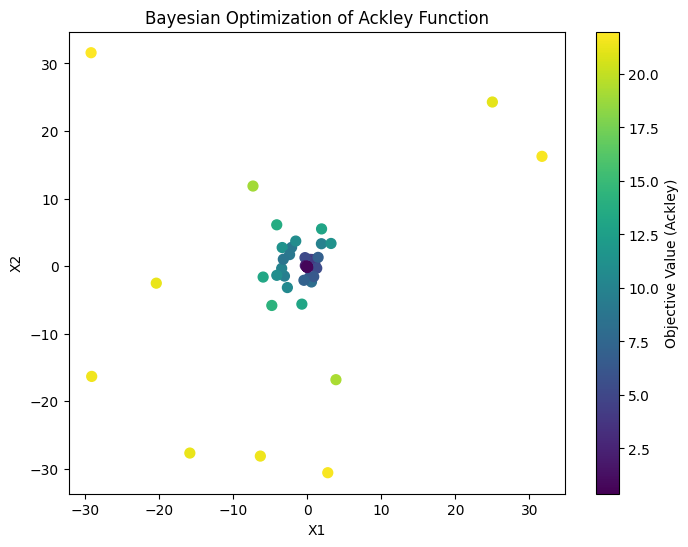

In [178]:
# Run optimization
results = simple_BO(synthetic, 50, 'UCB', 1, kappa=1.0)

X = results['inputs']
Y = results['outputs']

# Visualize results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=Y.squeeze().numpy(), cmap="viridis", s=50)
plt.colorbar(label="Objective Value (Ackley)")
plt.title("Bayesian Optimization of Ackley Function")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Simple GP on Hartmann 6-D with UCB(kappa=5)

In [135]:
# Problem setup
d = 6
synthetic = SyntheticTestFun('hartmann', d, negate=False, noise=0.0)

In [137]:
# Run optimization
results = simple_BO(synthetic, 100, 'UCB', 1, kappa=5.0)

tensor([-1.6980], dtype=torch.float64)
Iter 00: X=[[0.21892876 0.         0.26213906 0.35551925 0.17945279 0.89630437]], Y=-1.3407934325030049
Iter 03: X=[[0.064045   0.07276318 0.         0.33248325 0.28609754 0.69518551]], Y=-2.1172756331183105
Iter 06: X=[[0.04516175 0.04082327 0.53383952 0.18947107 0.26168835 0.7013077 ]], Y=-2.5579682804135633
Iter 09: X=[[0.         0.11218208 0.53523596 0.29575024 0.31004773 0.69922731]], Y=-2.748497621448031
Iter 12: X=[[0.         0.12247213 0.46927701 0.25003096 0.37480888 0.81559322]], Y=-2.1749586294082994
Iter 15: X=[[0.         0.15517481 0.43430924 0.31929584 0.26749674 0.73645144]], Y=-2.577075710945089
Iter 18: X=[[0.         0.30332041 0.55933182 0.2736201  0.31608952 0.6321267 ]], Y=-2.56544806782388
Iter 21: X=[[0.3059227  0.13460846 0.52625514 0.25918213 0.31630141 0.63898744]], Y=-3.1396212089564957
Iter 24: X=[[0.25734114 0.10389631 0.44558328 0.2638735  0.34275242 0.65154364]], Y=-3.2003492044297603
Iter 27: X=[[0.25471447 0.218

# Additive Structure: Hartmann 6

In [123]:
# Problem setup
d = 6
synthetic = SyntheticTestFun('hartmann', d, negate=False, noise=0.0)
n_models = 3
T = 200

In [124]:
# Run optimization
results_h = additive_BO(synthetic, T, 'UCB', n_models, kappa=5.0)

tensor([-2.9183], dtype=torch.float64)
This is partitions: [[[5, 1], [0, 2, 3, 4]], [[3, 5], [0, 1, 2, 4]], [[4, 1], [0, 2, 3, 5]]]
Iter 00: X=[[0.2911312  1.         0.51728965 0.4424065  0.43463119 0.        ]], Y=-1.8702975070997803
Iter 05: X=[[0.46689476 1.         0.40718875 0.51085679 0.45997092 0.        ]], Y=-2.471770637741713
Iter 10: X=[[0.30979138 1.         0.34987972 0.63437944 0.68887684 0.        ]], Y=-2.218418894777002
Iter 15: X=[[0.4569084  1.         0.         0.59200209 0.49493204 0.        ]], Y=-2.5366936501418045
Iter 20: X=[[0.46502795 1.         0.         0.51069154 0.5216705  0.        ]], Y=-2.4012744500676084
Iter 25: X=[[0.46175845 1.         0.         0.51326473 0.52217658 0.        ]], Y=-2.424629917273987
Iter 30: X=[[0.45988208 1.         0.         0.51532044 0.52297045 0.        ]], Y=-2.4391535470868733
Iter 35: X=[[0.46696127 1.         0.43537509 0.60385404 0.53980242 0.        ]], Y=-2.536274161275992
Iter 40: X=[[0.38114653 1.         0.   

C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\1289144393.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\1289144393.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


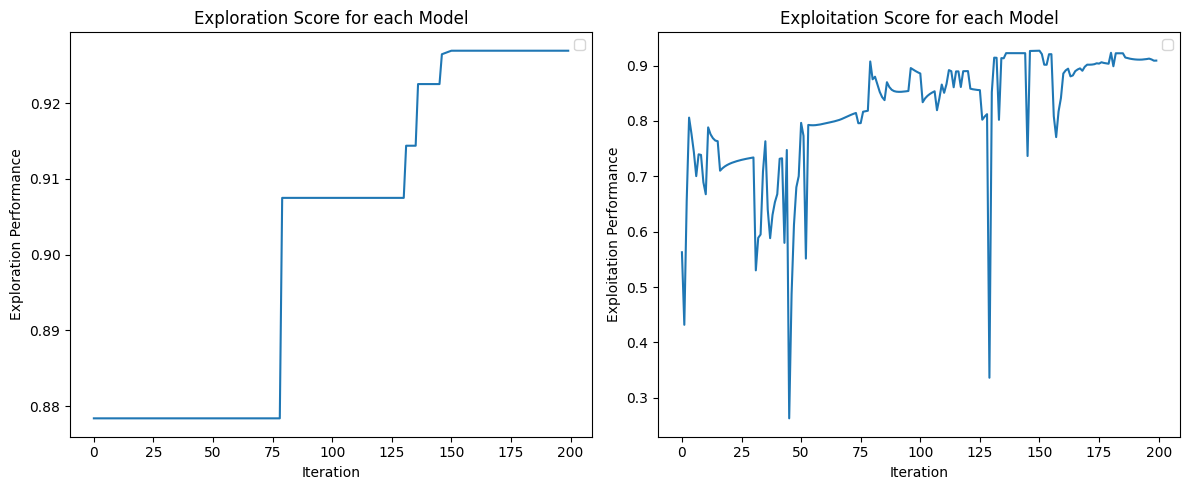

In [125]:
plot_exploration_exploitation(results_h['exploration'], results_h['exploitation'],T)


In [126]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_h['predictions']]


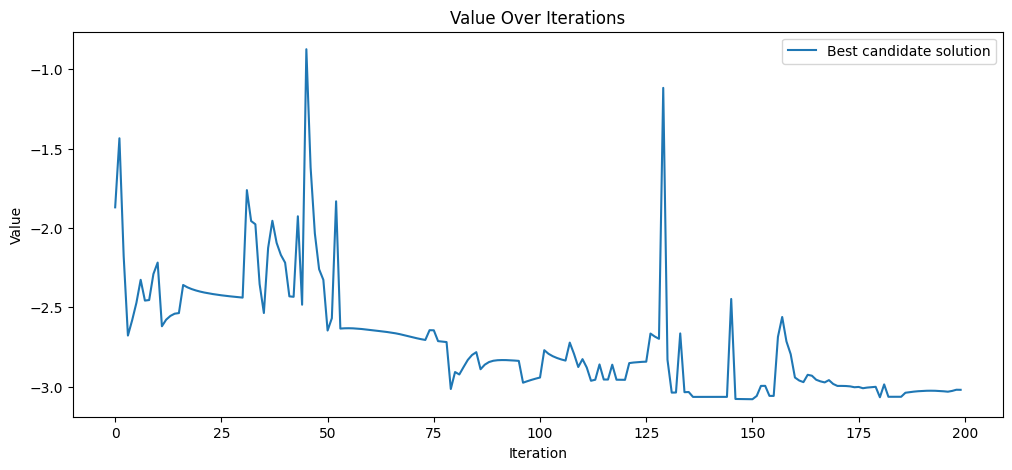

In [127]:
plot_values(values, T)

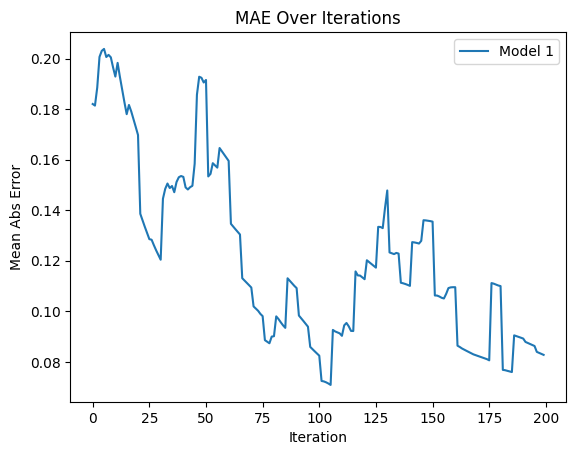

In [130]:
plot_mae(results_h['mae_overall'], T)

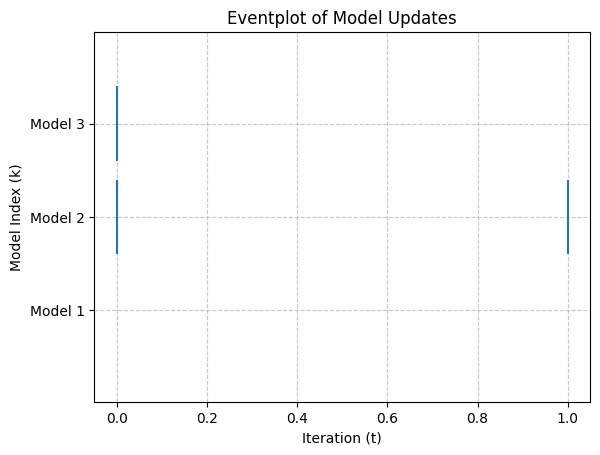

In [134]:
plot_partition_updates(results_h['partitions_updates'], n_models, T)


# Simple GP on Michalewicz 10d

In [139]:
# Problem setup
d = 10
synthetic = SyntheticTestFun('michaelwicz', d, negate=False, noise=0.0)
n_models = 50
T = 500

In [140]:
results = simple_BO(synthetic, T, 'UCB', 1, kappa=5.0)

tensor([-1.9103], dtype=torch.float64)
Iter 00: X=[[0.69747728 0.72319761 1.04937525 0.34118284 0.48496725 0.96273336
  0.95522294 0.55641578 0.74728404 0.2966546 ]], Y=-1.3647917468176018
Iter 03: X=[[0.28386211 0.44276996 0.21407477 0.7577289  0.12967233 0.02681194
  0.92865361 0.3899393  0.38126049 0.40325172]], Y=-0.22816453474900944
Iter 06: X=[[1.81921525 0.42550165 1.28389433 0.94644366 0.80852429 0.43517352
  2.22983256 1.58469394 2.13555671 2.88222386]], Y=-2.0417395757938794
Iter 09: X=[[1.47693339 0.53439794 1.25946324 0.93994996 0.98217723 0.4251163
  2.26887845 1.59005139 2.1625582  3.10128188]], Y=-1.9226779168429793
Iter 12: X=[[0.56007396 1.03003871 0.49994779 0.45473951 1.27960521 0.68792699
  0.22957537 0.80977106 0.56461252 0.469389  ]], Y=-0.6666430724198622
Iter 15: X=[[2.21030544 0.42798618 1.21902408 1.119709   1.00093586 0.48809397
  2.09576268 1.3530358  2.34350689 3.00564297]], Y=-4.228542814196678
Iter 18: X=[[2.42274888 0.49874104 1.26448973 1.08037735 1.006

C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


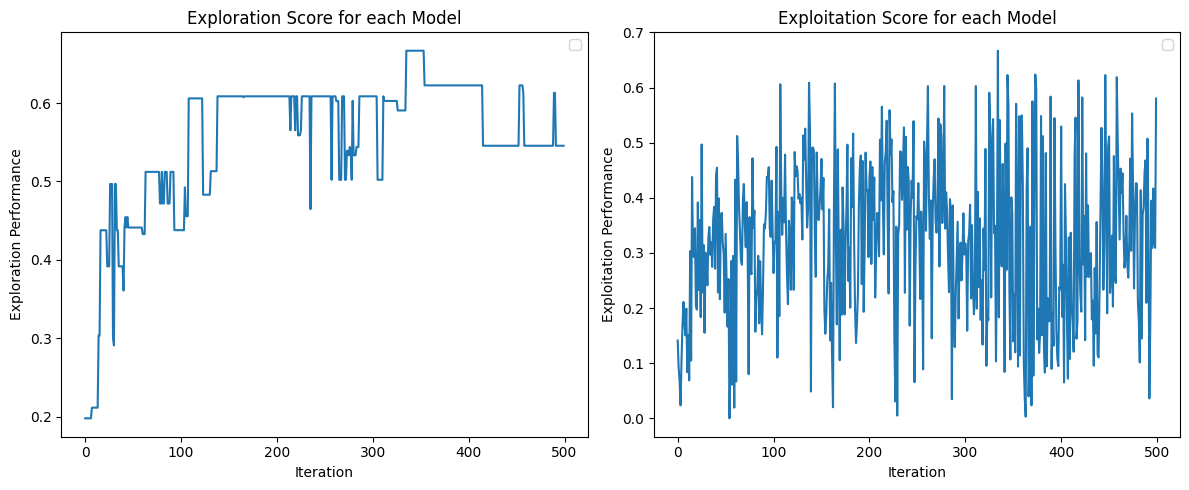

In [142]:
plot_exploration_exploitation(results['exploration'], results['exploitation'],T)


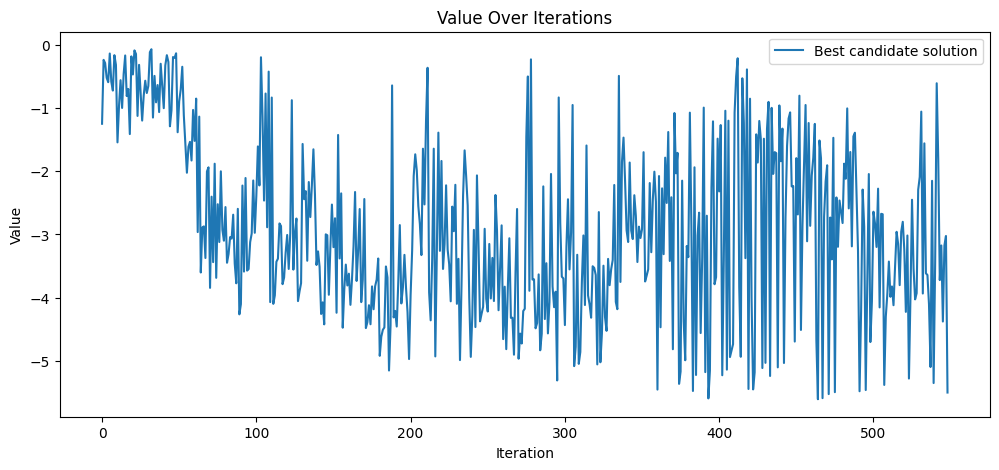

In [154]:
plot_values(results['predictions'].detach().numpy(), T + 49)

# AdditiveStruct Michalewicz

In [10]:
# Problem setup
d = 10
synthetic = SyntheticTestFun('michaelwicz', d, negate=False, noise=0.0)
n_models = 20
T = 500

## UCB, kappa = 8, 10 models

In [164]:
# Run optimization
results_m = additive_BO(synthetic, T, 'UCB', n_models, kappa=8.0)

tensor(-2.7944, dtype=torch.float64)
This is partitions: [[[9, 1, 0], [2, 3, 4, 5, 6, 7, 8]], [[5, 1, 2], [0, 3, 4, 6, 7, 8, 9]], [[5, 7, 8], [0, 1, 2, 3, 4, 6, 9]], [[9, 5, 2], [0, 1, 3, 4, 6, 7, 8]], [[0, 3, 6], [1, 2, 4, 5, 7, 8, 9]], [[4, 6, 3], [0, 1, 2, 5, 7, 8, 9]], [[7, 4, 0], [1, 2, 3, 5, 6, 8, 9]], [[0, 4, 9], [1, 2, 3, 5, 6, 7, 8]], [[1, 5, 0], [2, 3, 4, 6, 7, 8, 9]], [[0, 4, 7], [1, 2, 3, 5, 6, 8, 9]]]
Iter 00: X=[[3.14159265 0.25092945 1.37678691 2.23159013 0.67396657 2.08076111
  2.26506693 1.10271183 2.58354267 0.36703257]], Y=-0.8063842366230678
Iter 02: X=[[2.22763808 0.23328759 1.14183541 2.37754894 2.38937065 1.70332586
  2.15446083 1.28584978 3.06795346 0.40390582]], Y=-1.2210847954393824
Iter 04: X=[[2.13762586 0.3614004  1.15000449 1.97002597 1.94657304 2.05137198
  2.35731868 1.21785201 2.53156342 0.75870072]], Y=-2.605509206577253
Iter 06: X=[[1.82790537 0.0417773  1.01655147 2.42533331 1.64373455 1.74952352
  2.01166655 1.22561808 2.7255206  0.72083608]], Y=-1.

C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


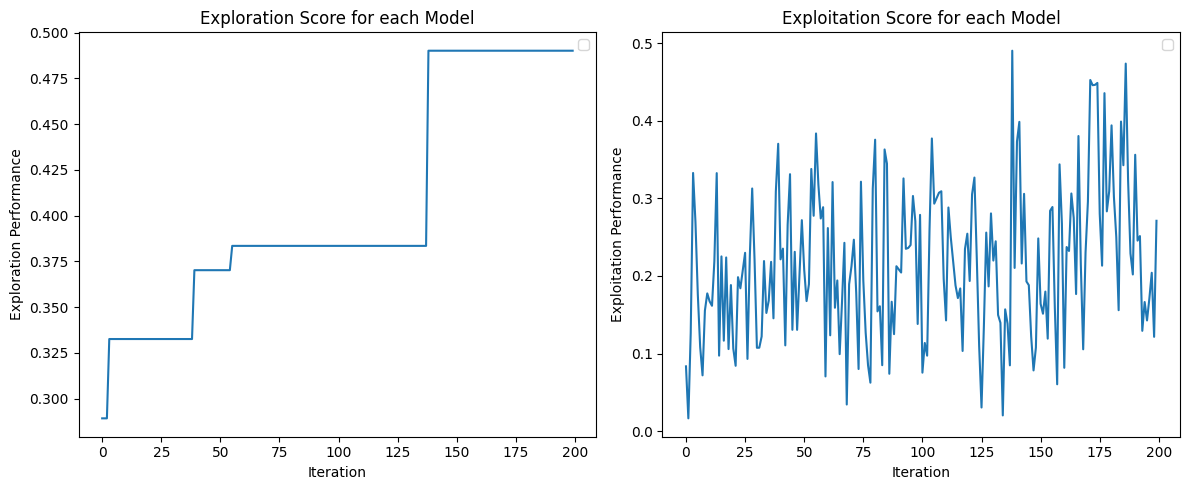

In [169]:
plot_exploration_exploitation(results_m ['exploration'], results_m ['exploitation'],T)

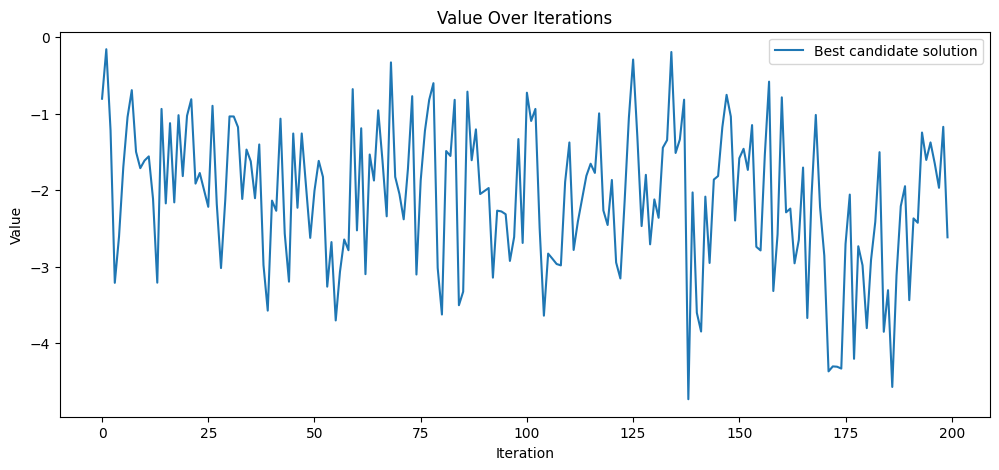

In [170]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m['predictions']
]
plot_values(values, T)

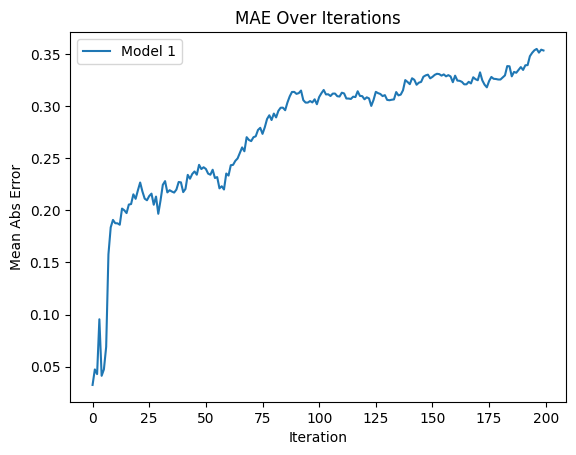

In [171]:
plot_mae(results_m['mae_overall'], T)

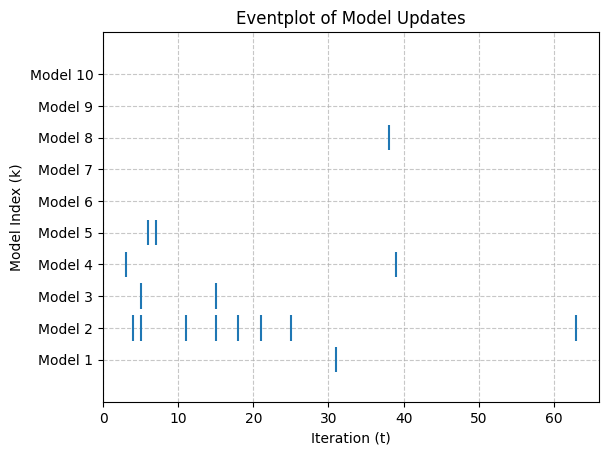

In [172]:
plot_partition_updates(results_m['partitions_updates'], n_models, T)


## EI, models = 50

In [173]:
results_m2 = additive_BO(synthetic, T, 'EI', n_models)

tensor(-3.8940, dtype=torch.float64)
This is partitions: [[[4, 2, 6], [0, 1, 3, 5, 7, 8, 9]], [[0, 4, 7], [1, 2, 3, 5, 6, 8, 9]], [[1, 6, 3], [0, 2, 4, 5, 7, 8, 9]], [[0, 4, 2], [1, 3, 5, 6, 7, 8, 9]], [[6, 3, 4], [0, 1, 2, 5, 7, 8, 9]], [[5, 3, 9], [0, 1, 2, 4, 6, 7, 8]], [[0, 1, 5], [2, 3, 4, 6, 7, 8, 9]], [[0, 4, 2], [1, 3, 5, 6, 7, 8, 9]], [[5, 6, 1], [0, 2, 3, 4, 7, 8, 9]], [[1, 9, 3], [0, 2, 4, 5, 6, 7, 8]]]
Iter 00: X=[[2.15369867 0.26355933 0.65368051 1.09841754 1.60896284 2.01449013
  0.88438829 2.04198723 1.70641865 0.36451362]], Y=-3.3432354248145773
Iter 02: X=[[2.19162386 0.18506744 0.55815568 1.00242432 2.22078864 1.91313802
  0.82725317 1.95150009 1.724789   0.24098987]], Y=-2.67995210024332
Iter 04: X=[[2.16125828 0.4189496  0.89965395 0.98844793 2.02047745 1.90592968
  0.51623525 2.04228887 1.70968605 0.39916205]], Y=-1.326464488534167
Iter 06: X=[[2.32315833 0.25007763 0.70983968 0.93271637 2.81182835 2.09188726
  0.98136702 1.86404073 2.04349787 0.41084884]], Y=-0.76

C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_13144\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


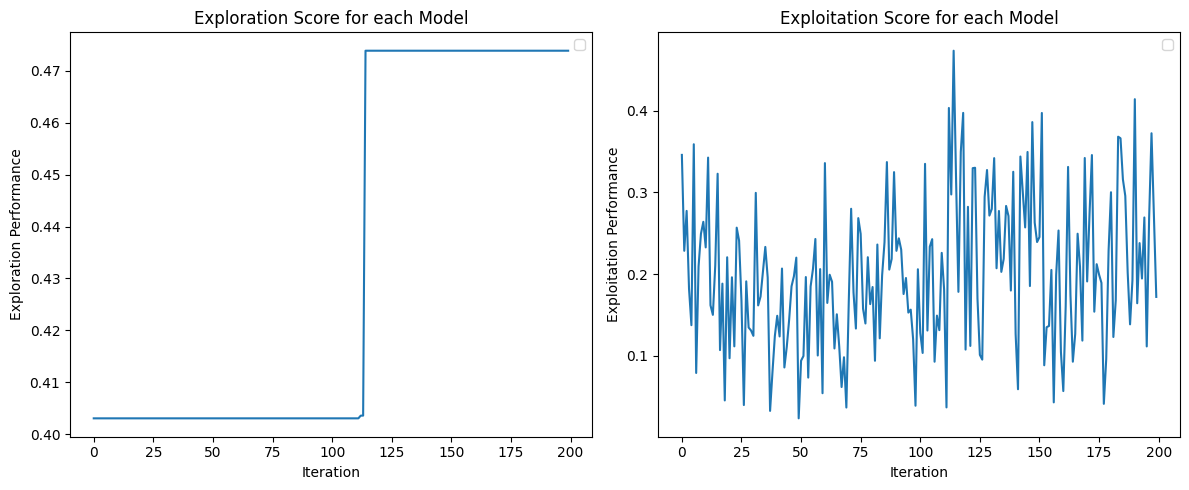

In [174]:
plot_exploration_exploitation(results_m2['exploration'], results_m2['exploitation'],T)

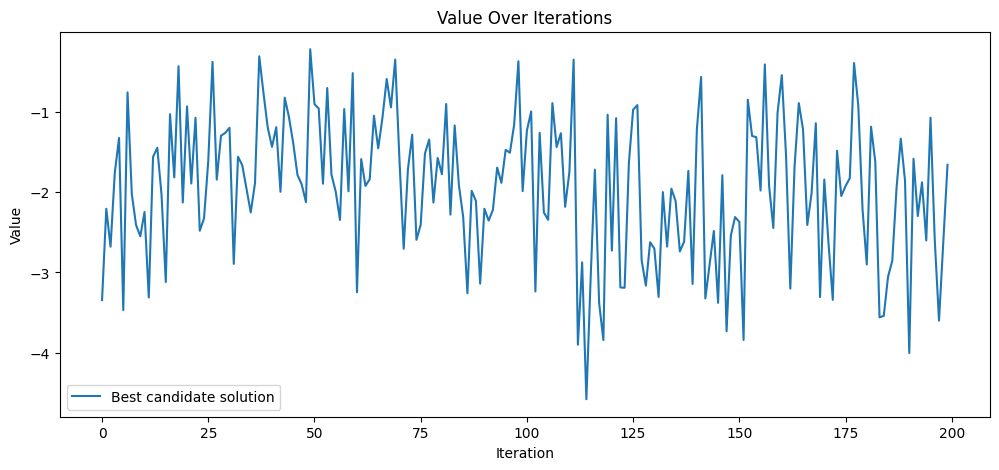

In [175]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m2['predictions']
]
plot_values(values, T)

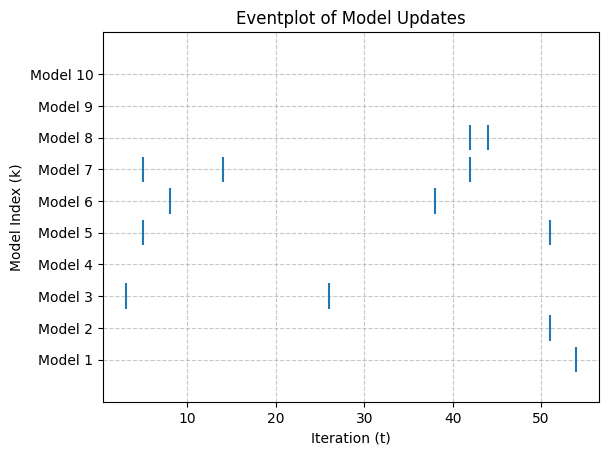

In [176]:
plot_partition_updates(results_m2['partitions_updates'], n_models, T)


## UCB kappa_max = 10, 20 models

In [20]:
results_m3 = additive_BO(synthetic, T, 'UCB', n_models, kappa=10.0)

tensor(-2.3166, dtype=torch.float64)
This is partitions: [[[4, 0, 5], [1, 2, 3, 6, 7, 8, 9]], [[7, 4, 3], [0, 1, 2, 5, 6, 8, 9]], [[5, 6, 4], [0, 1, 2, 3, 7, 8, 9]], [[7, 3, 0], [1, 2, 4, 5, 6, 8, 9]], [[9, 1, 0], [2, 3, 4, 5, 6, 7, 8]], [[2, 4, 3], [0, 1, 5, 6, 7, 8, 9]], [[3, 6, 2], [0, 1, 4, 5, 7, 8, 9]], [[8, 2, 4], [0, 1, 3, 5, 6, 7, 9]], [[3, 6, 1], [0, 2, 4, 5, 7, 8, 9]], [[1, 3, 6], [0, 2, 4, 5, 7, 8, 9]], [[2, 3, 6], [0, 1, 4, 5, 7, 8, 9]], [[7, 9, 5], [0, 1, 2, 3, 4, 6, 8]], [[9, 2, 0], [1, 3, 4, 5, 6, 7, 8]], [[1, 5, 9], [0, 2, 3, 4, 6, 7, 8]], [[0, 7, 2], [1, 3, 4, 5, 6, 8, 9]], [[9, 3, 8], [0, 1, 2, 4, 5, 6, 7]], [[6, 8, 3], [0, 1, 2, 4, 5, 7, 9]], [[2, 8, 3], [0, 1, 4, 5, 6, 7, 9]], [[2, 9, 7], [0, 1, 3, 4, 5, 6, 8]], [[6, 2, 3], [0, 1, 4, 5, 7, 8, 9]]]
Iter 00: X=[[2.07560187 1.52919549 2.12275721 2.75851972 2.97794137 1.63058747
  2.25219008 2.68944456 0.77889224 1.33084432]], Y=-2.9179565493955297
Iter 02: X=[[1.99297968 1.73020253 1.6441814  2.97160343 3.11367249 1.95

C:\Users\mauri\AppData\Local\Temp\ipykernel_10680\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_10680\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


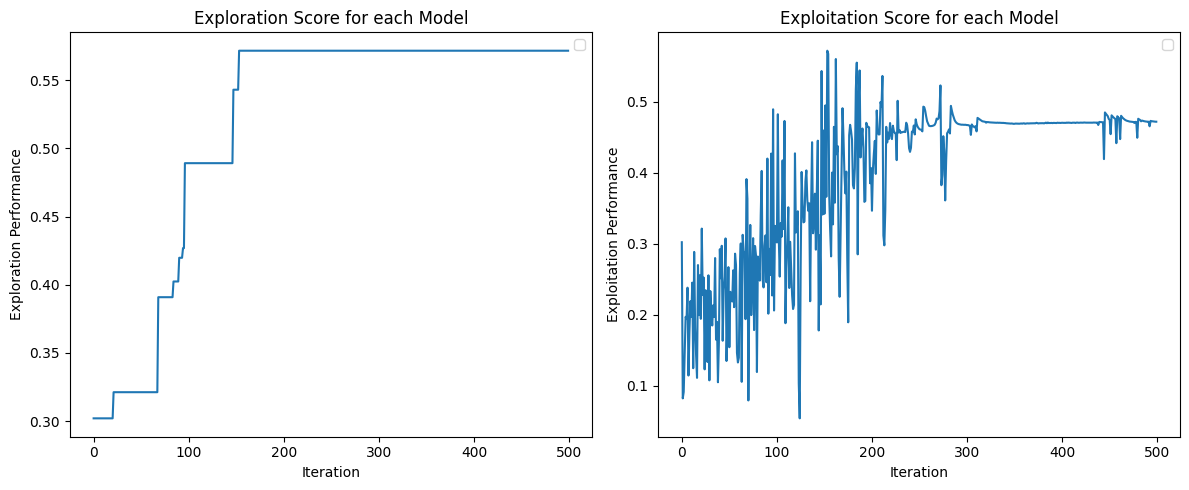

In [26]:
plot_exploration_exploitation(results_m3['exploration'], results_m3['exploitation'],T)

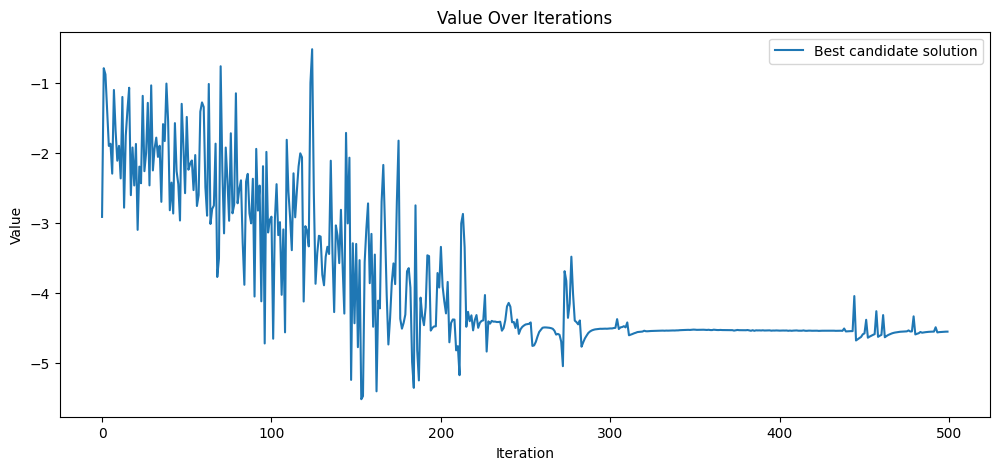

In [27]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m3['predictions']
]
plot_values(values, T)

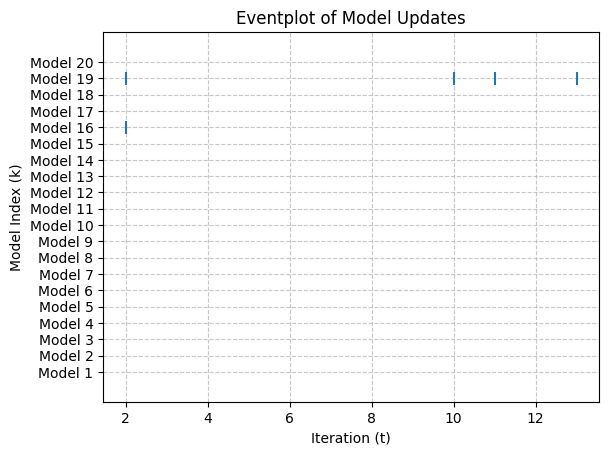

In [28]:
plot_partition_updates(results_m3['partitions_updates'], n_models, T)


In [24]:
gp_model = results_m3['model']

## UCB kappa_max = 10, 5 models

In [11]:
n_models = 5
T = 500

In [12]:
results_m4 = additive_BO(synthetic, T, 'UCB', n_models, kappa=10.0)

tensor(-3.0401, dtype=torch.float64)
This is partitions: [[[7, 9, 5], [0, 1, 2, 3, 4, 6, 8]], [[3, 1, 9], [0, 2, 4, 5, 6, 7, 8]], [[6, 4, 1], [0, 2, 3, 5, 7, 8, 9]], [[1, 9, 7], [0, 2, 3, 4, 5, 6, 8]], [[9, 0, 1], [2, 3, 4, 5, 6, 7, 8]]]
Iter 00: X=[[2.35942895 1.52014529 2.90005586 1.9694027  1.20694934 0.
  2.21368306 3.14159265 1.46750319 1.68377266]], Y=-2.85466021493616
Iter 02: X=[[2.30853074 1.51438398 2.28419932 2.15109317 1.7557399  0.78176925
  2.13081252 2.50154186 1.51816504 1.5597409 ]], Y=-3.567268524791325
Iter 04: X=[[1.75994564 1.361835   2.56434048 1.9503629  1.44132047 0.80501165
  2.08277661 2.60616351 1.14175737 1.35300545]], Y=-1.7545446860889213
Iter 06: X=[[2.37222072 1.54096939 2.25522718 2.2319673  1.76713519 0.2252756
  2.05182788 2.86691441 1.64719765 1.57102608]], Y=-4.472515586750565
Iter 08: X=[[2.33591708 1.48133802 2.43312048 2.56952696 1.72662846 0.37650686
  2.09583722 2.90266333 1.55985065 1.79777589]], Y=-2.285176975348431
Iter 10: X=[[2.3718833  1.

C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


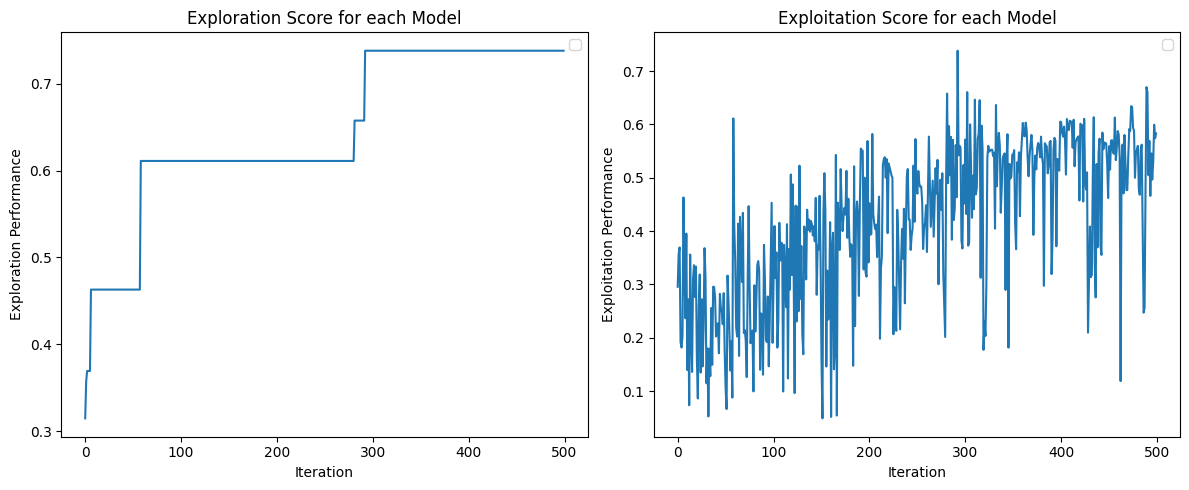

In [13]:
plot_exploration_exploitation(results_m4['exploration'], results_m4['exploitation'],T)

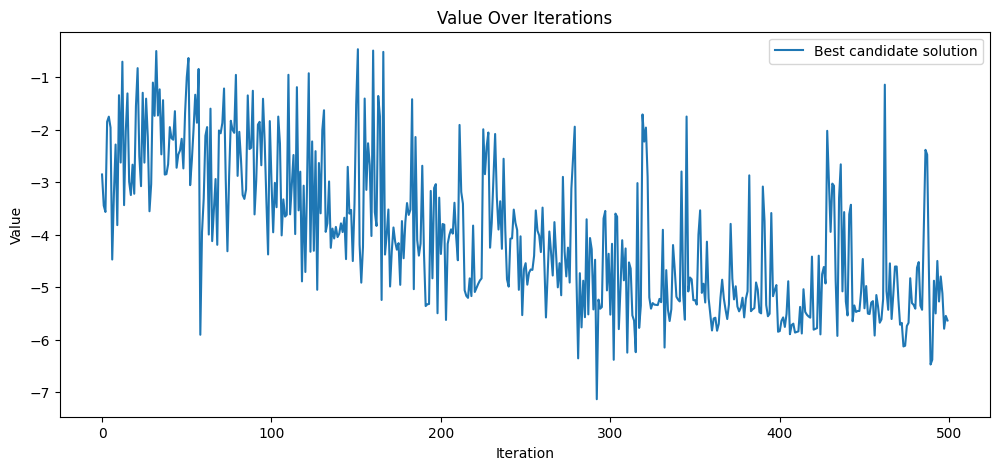

In [14]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m4['predictions']
]
plot_values(values, T)

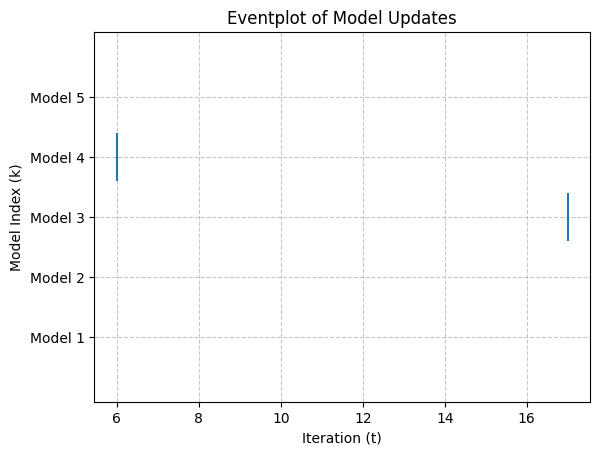

In [16]:
plot_partition_updates(results_m4['partitions_updates'], n_models, T)


## UCB kappa_max = 20, 5 models

In [27]:
n_models = 5
T = 350

In [28]:
results_m5 = additive_BO(synthetic, T, 'UCB', n_models, kappa=20.0)

tensor(-2.9318, dtype=torch.float64)
This is partitions: [[[1, 5, 7], [0, 2, 3, 4, 6, 8, 9]], [[5, 7, 3], [0, 1, 2, 4, 6, 8, 9]], [[6, 5, 3], [0, 1, 2, 4, 7, 8, 9]], [[4, 1, 2], [0, 3, 5, 6, 7, 8, 9]], [[3, 1, 8], [0, 2, 4, 5, 6, 7, 9]]]
Iter 00: X=[[2.07372527 1.32185109 0.89324555 0.         1.32140101 2.56066766
  1.18651648 1.43938083 0.         2.72388744]], Y=-1.11909537197672
Iter 02: X=[[1.98721121 1.70554896 1.72024658 1.04665917 0.86137702 3.14159265
  0.74147901 0.07895672 0.7246489  2.28037438]], Y=-2.4104020920511027
Iter 04: X=[[1.82978558 1.64887711 0.82446123 0.47211819 0.96096356 3.14128089
  0.71084828 0.         0.82319334 2.71868649]], Y=-2.2474356582010584
Iter 06: X=[[1.82506223 1.1537083  0.98901772 1.30393739 1.42933818 3.14159265
  0.95436204 0.3598821  0.32692659 2.47328878]], Y=-0.19133896778705298
Iter 08: X=[[1.45982794 1.17525932 1.33365912 0.70636244 0.68892856 2.88812164
  1.32655162 0.         0.68523674 2.49309119]], Y=-1.2182030445981096
Iter 10: X=[[

C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


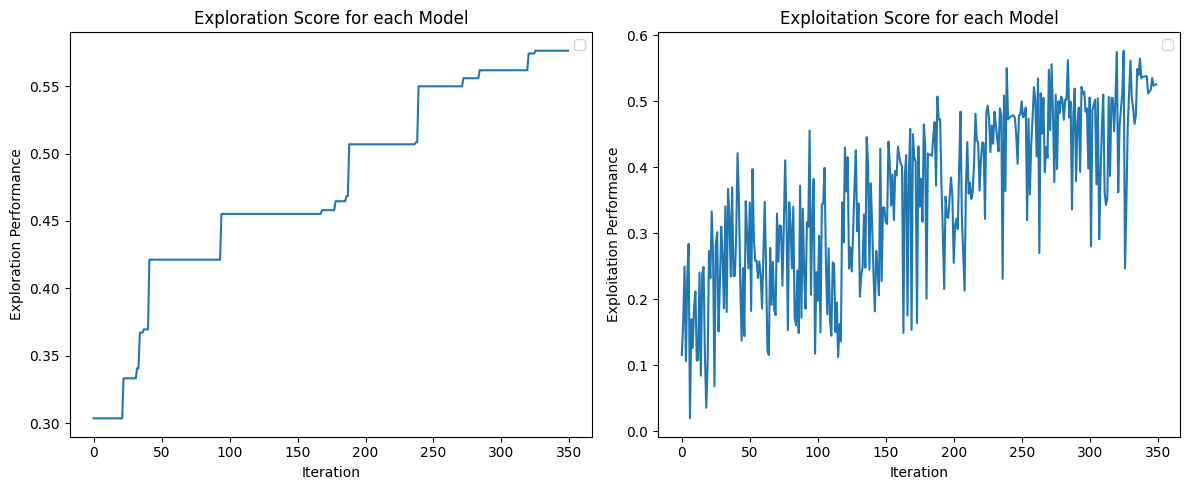

In [31]:
plot_exploration_exploitation(results_m5['exploration'], results_m5['exploitation'],T)

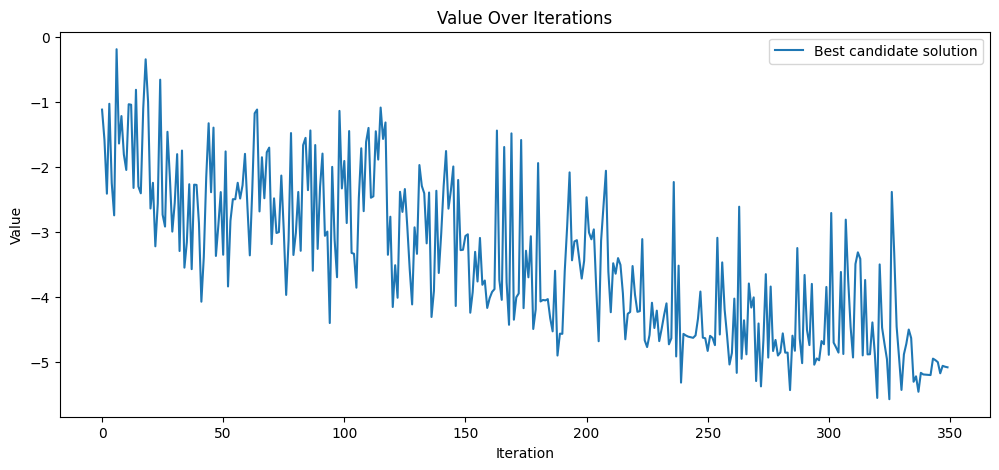

In [32]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m5['predictions']
]
plot_values(values, T)

## UCB kappa_max = 20, 10 models

In [34]:
n_models = 10
T = 400

In [35]:
results_m6 = additive_BO(synthetic, T, 'UCB', n_models, kappa=20.0)

tensor(-2.6372, dtype=torch.float64)
This is partitions: [[[0, 2, 8], [1, 3, 4, 5, 6, 7, 9]], [[7, 5, 4], [0, 1, 2, 3, 6, 8, 9]], [[8, 0, 1], [2, 3, 4, 5, 6, 7, 9]], [[6, 5, 9], [0, 1, 2, 3, 4, 7, 8]], [[1, 7, 9], [0, 2, 3, 4, 5, 6, 8]], [[7, 3, 5], [0, 1, 2, 4, 6, 8, 9]], [[4, 0, 3], [1, 2, 5, 6, 7, 8, 9]], [[4, 2, 8], [0, 1, 3, 5, 6, 7, 9]], [[8, 6, 0], [1, 2, 3, 4, 5, 7, 9]], [[0, 5, 6], [1, 2, 3, 4, 7, 8, 9]]]
Iter 00: X=[[1.89526343 0.4081925  0.43988977 1.77774753 1.7743911  1.09077697
  0.58099905 0.         2.80842002 0.56474942]], Y=-0.5705369559952005
Iter 02: X=[[1.8153634  0.3399701  1.11482535 2.07615287 1.95028862 1.95266394
  0.52120427 0.24800529 1.72693243 0.28123613]], Y=-0.28924867116012726
Iter 04: X=[[1.74810059 0.         1.43652411 2.18805617 1.90816182 1.13994515
  0.41137614 0.         2.31531264 0.        ]], Y=-0.21346539154069114
Iter 06: X=[[1.63947098 2.50966587 1.58533019 0.13764756 1.0702039  2.09556182
  1.87721453 2.14764579 2.53841482 1.03298094]], Y=

C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


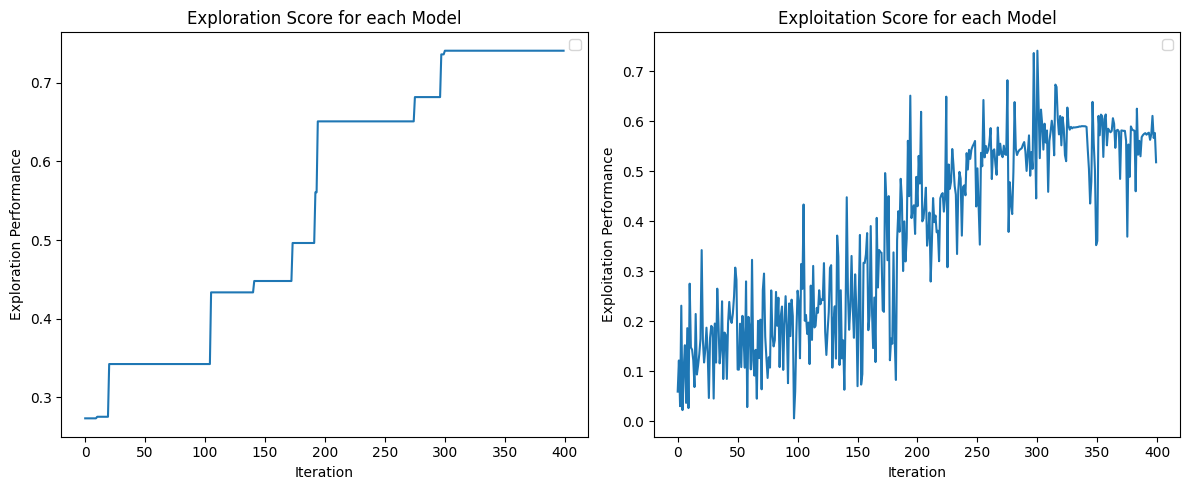

In [36]:
plot_exploration_exploitation(results_m6['exploration'], results_m6['exploitation'],T)

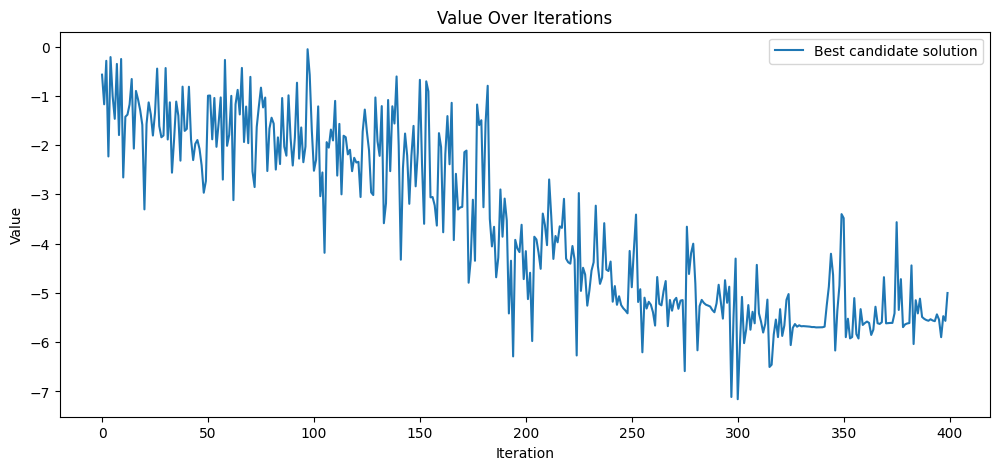

In [37]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m6['predictions']
]
plot_values(values, T)

In [46]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl (390.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [47]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[]


## UCB kappa_max = 10, 3 models

In [52]:
n_models = 3
T = 400

In [59]:
results_m7 = additive_BO(synthetic, T, 'UCB', n_models, kappa=10.0)

tensor(-2.8386, dtype=torch.float64)
This is partitions: [[[5, 7, 3], [0, 1, 2, 4, 6, 8, 9]], [[2, 6, 1], [0, 3, 4, 5, 7, 8, 9]], [[3, 0, 2], [1, 4, 5, 6, 7, 8, 9]]]
Iter 00: X=[[2.36294723 1.62256664 1.86906046 0.87732679 0.09158559 0.08229289
  2.18930314 1.04245284 1.73768961 1.00570798]], Y=-1.6657485652814579
Iter 02: X=[[2.49289045 1.66215973 1.17439867 0.89427751 1.28649845 0.66876974
  2.82787412 1.61741692 0.52734852 2.42969903]], Y=-1.3367397747901535
Iter 04: X=[[1.78991998 1.09605544 1.46527886 1.36623978 2.73379184 1.19372432
  2.11854355 1.51867599 0.         3.14159265]], Y=-0.13175139397418806
Iter 06: X=[[2.15695266 1.52241999 0.99775075 0.77233302 2.51270347 1.57173814
  2.05740315 1.40498838 0.         3.14159265]], Y=-3.055209690312855
Iter 08: X=[[2.183932   1.44247494 1.35020442 1.1389234  2.45580075 1.80020992
  2.30956685 1.5586853  0.47280964 3.14159265]], Y=-2.9136857182153624
Iter 10: X=[[2.19899699 1.62225964 1.35246117 1.28749176 2.43195393 1.85251451
  1.8

C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\mauri\AppData\Local\Temp\ipykernel_14664\3416398963.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


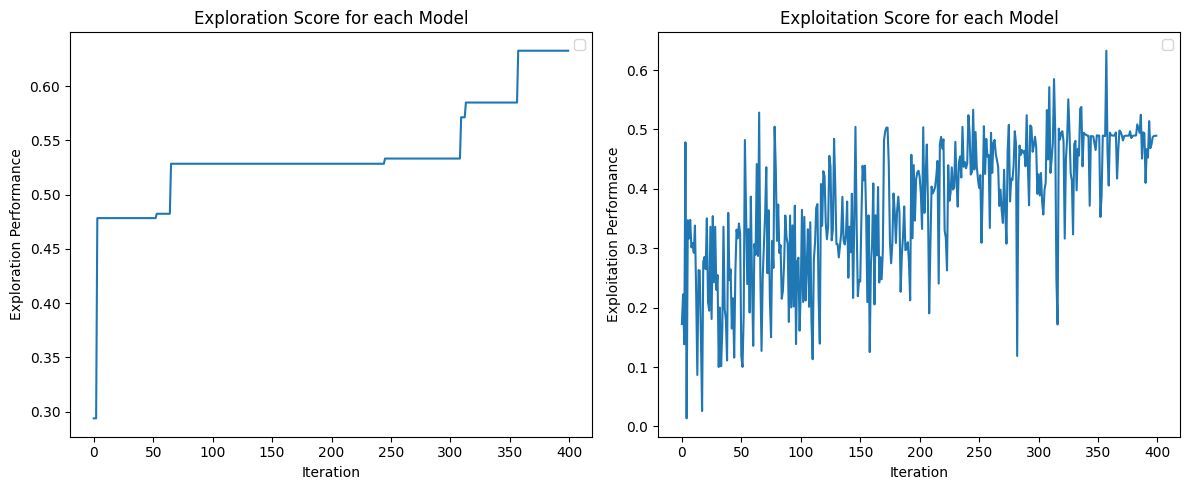

In [60]:
plot_exploration_exploitation(results_m7['exploration'], results_m7['exploitation'],T)

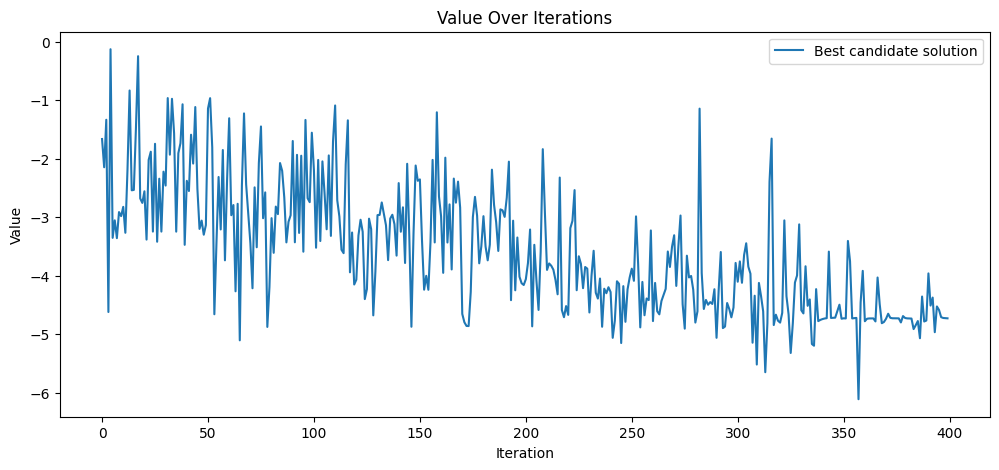

In [61]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m7['predictions']
]
plot_values(values, T)

## UCB kappa_max = 20, 10 models, but with weighted_forward and weighted_candidate

In [66]:
n_models = 10
T = 400

In [77]:
results_m8 = additive_BO2(synthetic, T, 'UCB', n_models, kappa=20.0)

tensor(-3.4624, dtype=torch.float64)


ValueError: Expected value argument (Parameter of shape (1,)) to be within the support (GreaterThan(lower_bound=0.0)) of the distribution LogNormalPrior(), but found invalid values:
Parameter containing:
tensor([-0.0033], dtype=torch.float64, requires_grad=True)

In [ ]:
plot_exploration_exploitation(results_m8['exploration'], results_m8['exploitation'],T)

In [ ]:
values = [t.item() if t.numel() == 1 else t.squeeze().numpy() for t in results_m8['predictions']
]
plot_values(values, T)